In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
#저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file =  os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

#pixelLib이 제공하는 모델의 url이다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

#다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f74492413d0>)

In [3]:
#다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [4]:
#PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

# 1. 고양이 이미지 - 배경 흐리게 하기

(401, 300, 3)


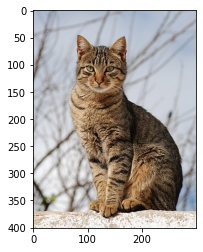

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

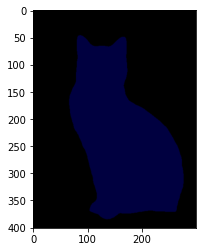

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [11]:
colormap[8]

array([64,  0,  0])

In [12]:
seg_color = (0, 0, 64)

(401, 300)


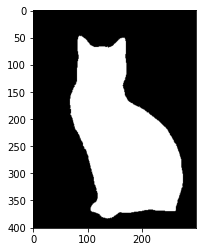

In [13]:
seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap = 'gray')
plt.show()

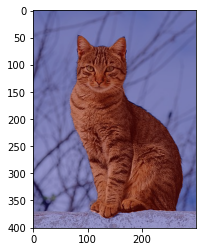

In [14]:
#원래 이미지와 겹쳐서 세그멘테이션이 얼마나 잘 됐는지 한 번 알아보기
img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

#255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율이다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

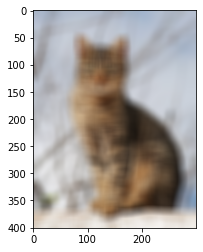

In [15]:
#blur() 함수로 배경을 흐리게하기
#(13, 13)은 blurring kernel size를 뜻한다.
#다양하게 바꿔보자

img_orig_blur = cv2.blur(img_orig, (20, 20))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

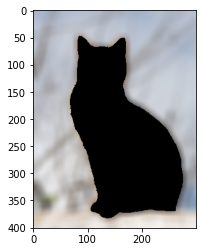

In [16]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

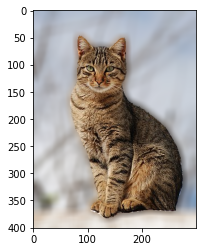

In [17]:
#배경과 사람 합치기
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 고양이가 있는 장소를 바꿔보자! - 크로마키 적용 해보기

고양이가 설원에 혼자 있는 걸 보니까 너무 외로워 보인다.

한번쯤은 기분 전환을 위해 가보지 않았던 곳, 이제껏 느껴지보지 못했던 당황스러운 감정을 느껴보는 것도 나쁘지 않을 것 같다.

그러니 고양이를 허스키 떼의 중심에 데려다 주자

(612, 368, 3)
(401, 300, 3)


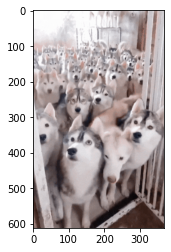

In [18]:
husky_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/허스키들.png'
husky_orig = cv2.imread(husky_path)

print(husky_orig.shape)
print(img_orig.shape)
plt.imshow(cv2.cvtColor(husky_orig, cv2.COLOR_BGR2RGB))
plt.show()

고양이 원본 사진의 사이즈는 (401, 300, 3)이고, 허스키의 이미지의 사이즈는 (612, 368, 3)이다.
사진 크기가 안 맞으니 크기를 맞춰줘야한다.

허스키 사진의 윗부분에는 허스키가 없으니까 중간쯤의 사진만 이용하고, 가로 사이즈도 적당히 지정해주자

In [19]:
husky_orig = husky_orig[50:451, 0:300]
husky_orig.shape

(401, 300, 3)

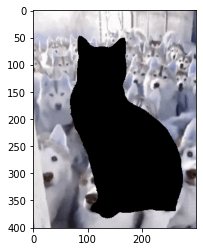

In [20]:
#cv2.bitwise_and 는 픽셀값이 0이 아닌 부분만 연산하여 합성한다.
#합성하는 이미지의 크기는 같아야 한다.
cat_bg = cv2.bitwise_and(husky_orig, img_bg_mask)

plt.imshow(cat_bg, cmap=plt.cm.binary_r)
plt.show()

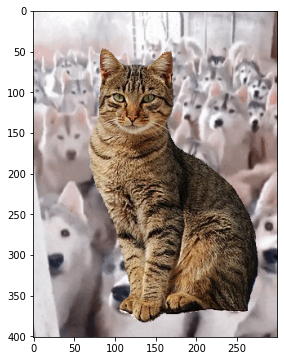

In [21]:
husky_concat = np.where(img_bg_mask==0,img_orig, cat_bg)

plt.figure(figsize=(16,6))
plt.imshow(cv2.cvtColor(husky_concat,cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

허스키들한테 둘러싸인 고양이 이미지 만들기 성공!

중간에 하다가 허스키는 썰매 개라서 눈 주변에 있으면 귀가 파란색인게 당연하다고 생각되어 주황색 귀가 잘못 된 줄 알고 봤는데, 원본의 허스키 귀가 그냥 주황색이었던 거였다.

# 3. 인물 사진 - 배경 흐리게 하기

(540, 540, 3)


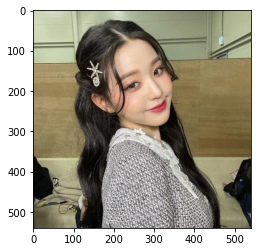

In [22]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/mang2.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
#모델에 이미지를 입력해 볼게요.
#output에 사진에서 영역 딴 거 들어감
segvalues, output = model.segmentAsPascalvoc(img_path)

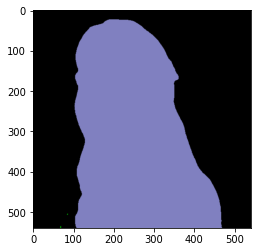

In [24]:
plt.imshow(output)
plt.show()

In [25]:
segvalues

{'class_ids': array([ 0, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [26]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
sofa


In [27]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[15]

array([192, 128, 128])

In [28]:
# BGR을 RGB 순서로 바꾸기
seg_color = (128, 128, 192)

(540, 540)


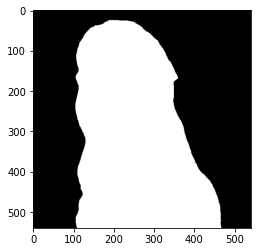

In [29]:
#seg_color로만 이루어진 마스크 만들어 보기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap = 'gray')
plt.show()

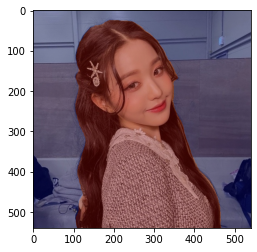

In [30]:
#원영이 사진에서 원영이를 검출해 보자

#원래 이미지와 겹쳐서 세그멘테이션이 얼마나 잘 됐는지 한 번 알아보기
img_show = img_orig.copy()

# True와 False인 값을 각각 255와 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

#255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

#원본 이미지와 마스크를 적당히 합쳐봅니다.
# 0.6과 0.4는 두 이미지를 섞는 비율이다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

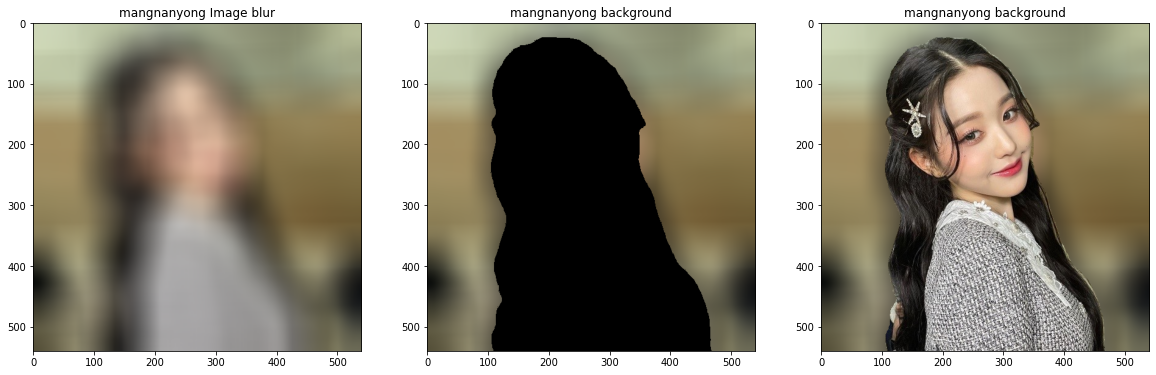

In [31]:
#blur() 함수로 배경을 흐리게하기
#다양하게 바꿔보자
img_orig_blur1 = cv2.blur(img_orig, (75, 75))

#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask)

#배경과 사람 합치기
img_concat1 = np.where(img_mask_color == 255, img_orig, img_bg_blur1)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig_blur1.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong Image blur')

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_bg_blur1.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img_concat1,cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

plt.show()

# 4&5. 가우시안 & Bilateral Filtering 양방향 블러 처리

인물사진 블러 처리시, 인물 머리카라긔 결계가 부자연스러운 것을 발견했다.

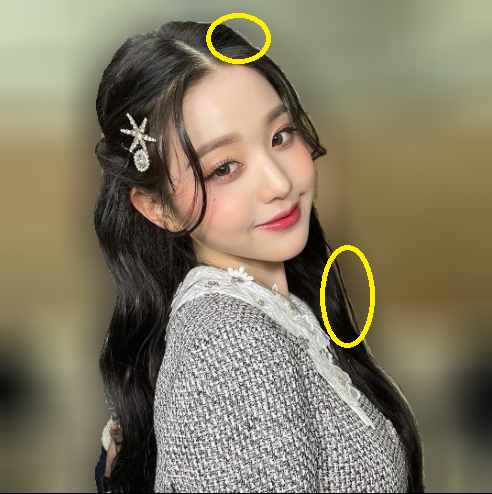

## OpenCV에서 제공하는 기술은 아래 네 가지이다.
1. Averaging: cv2.blur()

 : 블러 처리를 할 때 정규화 된 box filter를 이용하여 이미지를 블러처리함
 

2. Gaussian Filtering: cv2.gaussianBlur()

 ; 가우시안 함수를 통해 수학적으로 커널의 행렬 값을 생성해 사용한다. 이미지의 중앙 위치에 놓인 픽셀과 가까울 수록 가중치가 높아지고 멀어질 수록 가중치가 작아져 중앙 픽셀과 멀어질 수록 픽셀값에 대한 영향력이 작아진다.
 

3. Median Filtering: medianBlur()

 : kenel window에 있는 모든 픽셀들을 정렬한 후 중간 값을 선택하여 적용한다.
 

4. Bilateral Filtering: cv2.bilateralFilter()

 : 위의 블러처리들은 경계선까지 블러처리 되어 경계선이 흐려졌다면 이 양방향 필터링의 경우 경계선을 유지하면서 가우시안 필터링이 하는 것처럼 블러처리를 해주는 방법이다. 양방향 필터는 노이즈를 없애는 데 효율적이다.
 

경계선도 살리고 중앙에 위치한 인물을 제외한 나머지를 블러처리하기에는 양방향 필터링이 가장 괜찮을 것 같다고 생각되나, 노이즈를 없애는데 효과적이라 결과물이 어떨지는 장담을 못 할 것 같다.

일반 블러 함수보다 가우시안의 효과도 괜찮을 것 같으니 한 번 확인해보자.


# 4. 가우시안 블러처리

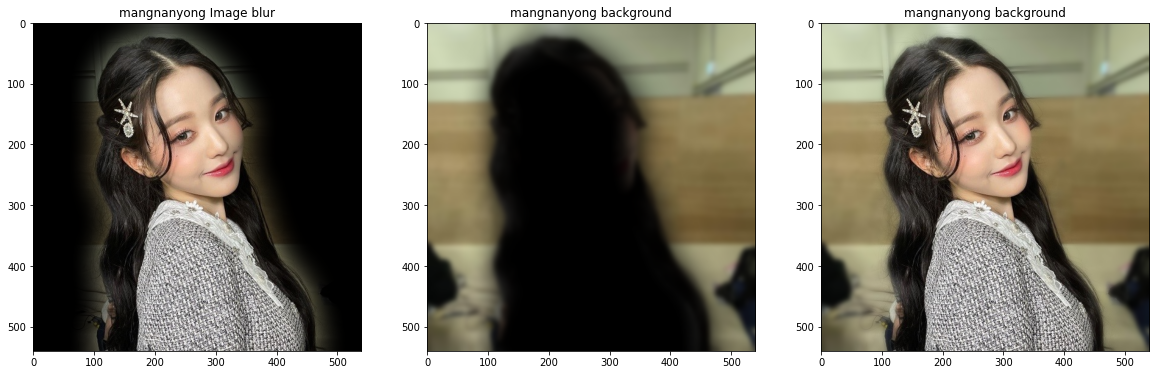

In [32]:
# 원본 사진과 마스크의 크기를 맞춰준다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
img_orig_blur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask2 = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
img_image_blur2 = img_Gmask2*img_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
img_bg_mask2 = (1-img_Gmask2)*img_orig_blur.astype(np.float32)
out2 = (img_image_blur2+img_bg_mask2).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_image_blur2.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong Image blur')

ax = plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img_bg_mask2.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

ax = plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(out2,cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

plt.show()

# 5. 양방향 블러처리

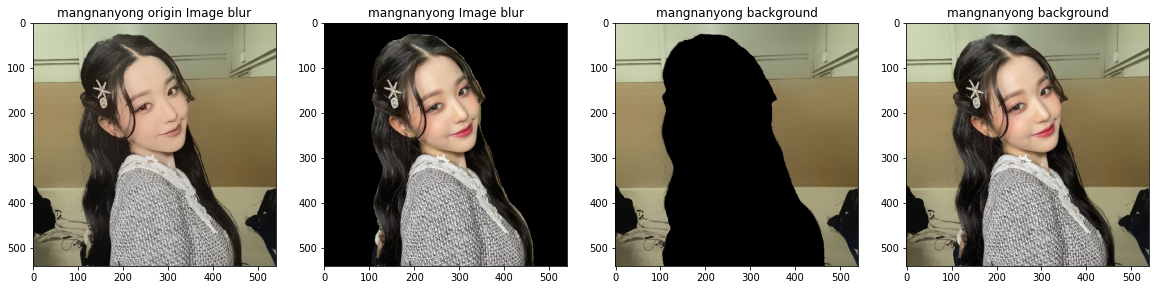

In [33]:
# 원본 사진과 마스크의 크기를 맞춰준다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)


k_size = 100
# 원본 이미지를 양방향 Blur 처리한다.
img_orig_blur3 = cv2.bilateralFilter(img_orig, k_size, 75, 75)
# 마스크 이미지를 양방향 Blur 처리한다.
img_Gmask3 = (cv2.bilateralFilter(img_mask_3C, k_size, 75, 75)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
img_image_blur3 = img_Gmask3*img_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
img_bg_mask3 = (1-img_Gmask3)*img_orig_blur3.astype(np.float32)
out3 = (img_image_blur3+img_bg_mask3).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img_orig_blur3.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong origin Image blur')

ax = plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(img_image_blur3.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong Image blur')

ax = plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(img_bg_mask3.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

ax = plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(out3,cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

plt.show()

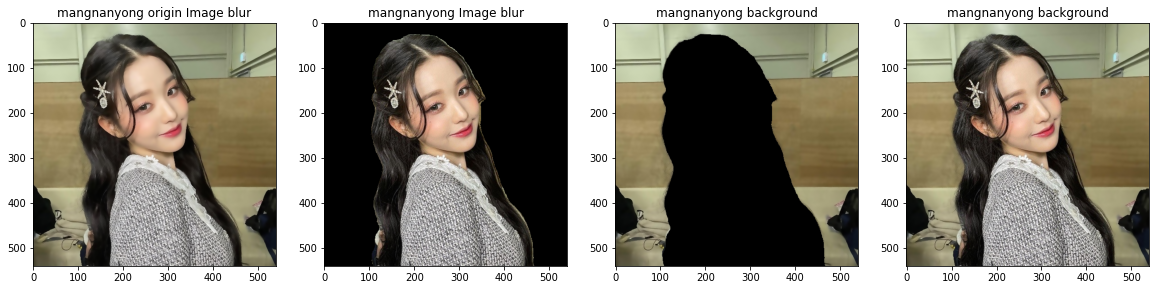

In [34]:
# 원본 사진과 마스크의 크기를 맞춰준다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)


k_size = 9
# 원본 이미지를 양방향 Blur 처리한다.
img_orig_blur4 = cv2.bilateralFilter(img_orig, k_size, 75, 75)
# 마스크 이미지를 양방향 Blur 처리한다.
img_Gmask4 = (cv2.bilateralFilter(img_mask_3C, k_size, 75, 75)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
img_image_blur4 = img_Gmask4*img_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
img_bg_mask4 = (1-img_Gmask4)*img_orig_blur4.astype(np.float32)
out4 = (img_image_blur4+img_bg_mask4).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img_orig_blur4.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong origin Image blur')

ax = plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(img_image_blur4.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong Image blur')

ax = plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(img_bg_mask4.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

ax = plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(out4,cv2.COLOR_BGR2RGB))
ax.set_title('mangnanyong background')

plt.show()

# 5.1. 양방향 블러에서 k_size의 영향

양방향 k_size =100
양방향 k_size =9


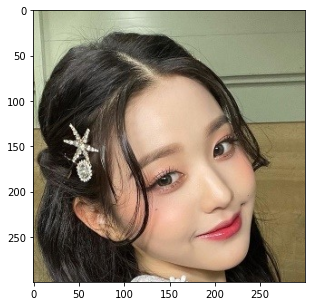

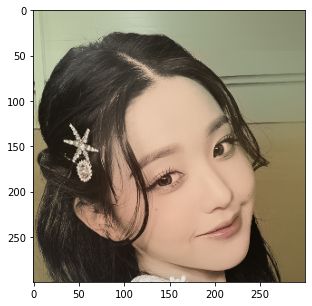

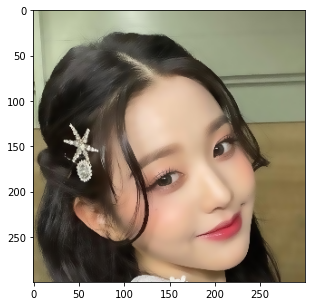

In [35]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img_orig[0:300, 100:400], cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

print('양방향 k_size =100')
fig = plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img_orig_blur3[0:300, 100:400].astype(np.uint8),cv2.COLOR_BGR2RGB))

print('양방향 k_size =9')
fig = plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img_orig_blur4[0:300, 100:400].astype(np.uint8),cv2.COLOR_BGR2RGB))

차례로 원본, k_size=100, k_size=9 일 때의 블러처리 된 사진이다.

두 사진 다 원본에 비해 원본에 비해 왼쪽 볼의 머리카락 그림자, 왼쪽 입 꼬리 쪽의 그림자가 옅어진 것을 확인할 수 있다.

k_size=100인 경우는 왼쪽 눈 밑의 점이 많이 흐려졌고, 눈두덩, 볼, 입술을 봤을 때 채도가 빠진 것을 확인할 수 있다.

k_size =9인 경우는 왼쪽 눈 밑의 점 조금 흐려졌고, 전체적인 사진의 채도는 유지된 것을 알 수 있다.


# 5.2. 머리카락 라인 비교

Text(0.5, 1.0, 'bilateralFilter k_size =9')

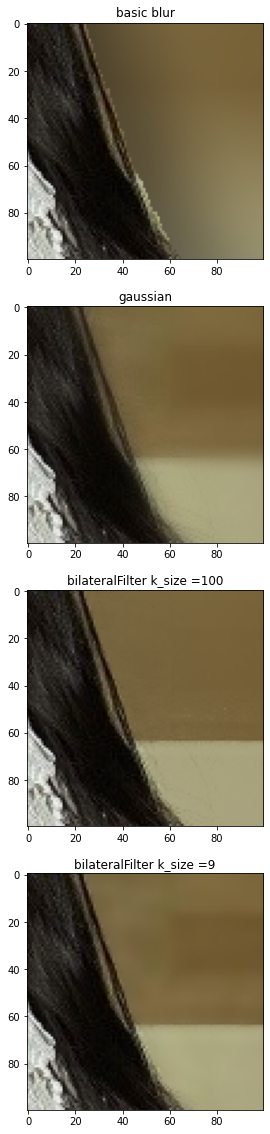

In [36]:
fig = plt.figure(figsize=(20, 20)) 

ax = plt.subplot(4,1,1)
plt.imshow(cv2.cvtColor(img_concat1[300:400, 350:450], cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('basic blur')

ax = plt.subplot(4,1,2)
plt.imshow(cv2.cvtColor(out2[300:400, 350:450], cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('gaussian')

ax = plt.subplot(4,1,3)
plt.imshow(cv2.cvtColor(out3[300:400, 350:450], cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('bilateralFilter k_size =100')

ax = plt.subplot(4,1,4)
plt.imshow(cv2.cvtColor(out4[300:400, 350:450], cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('bilateralFilter k_size =9')

* 머리카락 선의 경계를 보면, 기본 블러의 경계선이 가장 러프하고, 가우시안 효과의 경계선이 가장 부드럽게 풀어져있다. 양방향 블러의 경우, 가우시안의 효과에 경계선을 뚜렷하게 만들어주는 효과가 있는데, 보다시피 기본 블러보다는 부드럽고 가우시안 보다는 경계선이 뚜렷한 모습을 볼 수 있다.

* 그리고 k_size=100인 블러가 k_size=9인 블러보다 블러링이 더 잘 된 것을 위의 사진 기준[0:60, 40:100]의 나무 벽 무늬부분 비교를 통해 알 수 있다.

# 6. 기본블러, 가우시안, 양방향 블러의 자연스러운 정도 비교



Text(0.5, 1.0, 'bilateralFilter k_size =9')

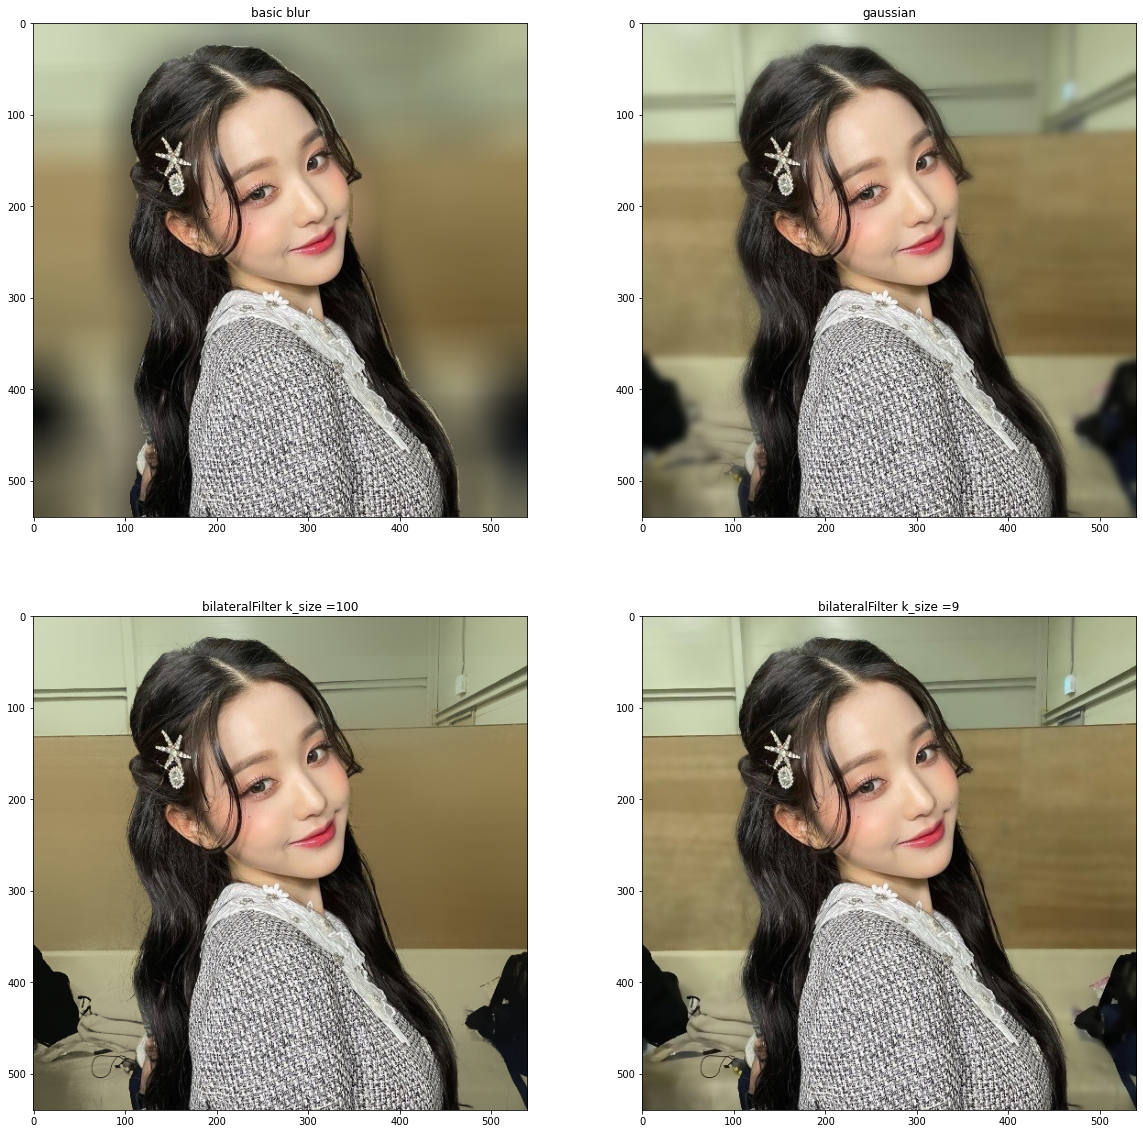

In [37]:
fig = plt.figure(figsize=(20, 20)) 

ax = plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('basic blur')

ax = plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('gaussian')

ax = plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(out3, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('bilateralFilter k_size =100')

ax = plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(out4, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('bilateralFilter k_size =9')

* 기본 블러의 경우 배경 블러링 정도를 낮추면 꽤 자연스러워질 수 있을 것 같지만, 그러면 블러하는 의미가 없을 것 같다.

* 양방향 필터가 블러링 하기에 가장 좋을 것 같았는데, 막상 하고 나니, 인물의 경계뿐만 아니라 배경에 있는 경계선들도 진하게 처리를 해서, 인물에만 포커스 효과를 주는 블러링을 하기에 좋은 필터는 아닌 것 같다.

**결과적으로, 경계선이 뚜렷하지 않지만, 그래도 가장 자연스러운 가우시안 블러가 사용하기에 제일 적합한 것 같다.**
